## Data Warehouse Design

In [ ]:
# Designing 2D & one fact table using SQLite through the star schema
import sqlite3
import pandas as pd
import numpy as np

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('star_schema.db')
cursor = conn.cursor()
# Create fact table
cursor.execute('''
CREATE TABLE IF NOT EXISTS sales (
    sale_id INTEGER PRIMARY KEY,
    product_id INTEGER,
    date TEXT,
    quantity INTEGER,
    revenue REAL,
    FOREIGN KEY (product_id) REFERENCES products(product_id)
)
''')
# Create dimensions table for products & dates
cursor.execute('''
CREATE TABLE IF NOT EXISTS products (
    product_id INTEGER PRIMARY KEY,
    product_name TEXT,
    category TEXT,
    subcategory TEXT
)
''')
cursor.execute('''
CREATE TABLE IF NOT EXISTS dates (
    date TEXT PRIMARY KEY,
    year INTEGER,
    quarter INTEGER,
    month INTEGER
)
''')
# Insert sample data into products dimension
products_data = [
    (1, 'Laptop', 'Electronics', 'Computers'),
    (2, 'Smartphone', 'Electronics', 'Mobile Phones'),
    (3, 'Tablet', 'Electronics', 'Mobile Devices'),
    (4, 'Headphones', 'Accessories', 'Audio'),
    (5, 'Camera', 'Electronics', 'Photography')
]
cursor.executemany('INSERT INTO products VALUES (?, ?, ?, ?)', products_data)
# Insert sample data into dates dimension
dates_data = [
    ('2023-01-15', 2023, 1, 1),
    ('2023-02-20', 2023, 1, 2),
    ('2023-03-10', 2023, 1, 3),
    ('2023-04-05', 2023, 2, 4),
    ('2023-05-25', 2023, 2, 5)
]
cursor.executemany('INSERT INTO dates VALUES (?, ?, ?, ?)', dates_data)
# Insert sample data into sales fact table
sales_data = [
    (1, 1, '2023-01-15', 2, 2000.00),
    (2, 2, '2023-02-20', 5, 2500.00),
    (3, 3, '2023-03-10', 3, 1500.00),
    (4, 4, '2023-04-05', 10, 1000.00),
    (5, 5, '2023-05-25', 1, 800.00)
]
cursor.executemany('INSERT INTO sales VALUES (?, ?, ?, ?, ?)', sales_data)
# Commit changes and close the connection
conn.commit()
cursor.close()
# Query to verify the data
sales_df = pd.read_sql_query('''
SELECT s.sale_id, p.product_name, s.date, s.quantity, s.revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
''', conn)
print(sales_df) 

   sale_id product_name        date  quantity  revenue
0        1       Laptop  2023-01-15         2   2000.0
1        2   Smartphone  2023-02-20         5   2500.0
2        3       Tablet  2023-03-10         3   1500.0
3        4   Headphones  2023-04-05        10   1000.0
4        5       Camera  2023-05-25         1    800.0


## OLAP Implementations

In [6]:
# Ensure the SQLite connection is open
import sqlite3

try:
    conn.execute("SELECT 1")
except sqlite3.ProgrammingError:
    conn = sqlite3.connect('star_schema.db')

# Relational OLAP
# 3 SQL Queries to demonstrate OLAP operations style aggregations

## 1. Roll-up: Total revenue by product category
rollup_query = '''
SELECT p.category, SUM(s.revenue) AS total_revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.category
'''
rollup_df = pd.read_sql_query(rollup_query, conn)
print("\nRoll-up: Total Revenue by Product Category")
print(rollup_df)

## 2. Drill-down: Total sales by year and month
drilldown_query = '''
SELECT d.year, d.month, SUM(s.revenue) AS total_revenue
FROM sales s
JOIN dates d ON s.date = d.date
GROUP BY d.year, d.month
'''
drilldown_df = pd.read_sql_query(drilldown_query, conn)
print("\nDrill-down: Total Sales by Year and Month")
print(drilldown_df)

#3 3. Slice: Best-selling products in a specific category (Electronics)
slice_query = '''
SELECT p.product_name, SUM(s.quantity) AS total_quantity
FROM sales s
JOIN products p ON s.product_id = p.product_id
WHERE p.category = 'Electronics'
GROUP BY p.product_name
ORDER BY total_quantity DESC
'''
slice_df = pd.read_sql_query(slice_query, conn)
print("\nSlice: Best-selling Products in Electronics Category")
print(slice_df)

# Multidimensional OLAP
# Building at least one cube using pandas pivot table (multidimensional aggregation)

## Create a DataFrame from the sales data
sales_df = pd.read_sql_query('''
SELECT s.sale_id, p.product_name, p.category, s.date, s.quantity, s.revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
''', conn)
# Convert date to datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])
# Extract year and month for better aggregation
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month
# Create a pivot table (cube) to analyze total revenue by category and month
cube = pd.pivot_table(sales_df, values='revenue', index=['category'],
                        columns=['year', 'month'], aggfunc=np.sum, fill_value=0)
print("\nMultidimensional OLAP Cube: Total Revenue by Category and Month")
print(cube)

# Hybrid OLAP
# Detailed data fetching using SQL (ROLAP) and summary data using pandas (MOLAP)

## Fetch detailed sales data for a specific product category (Electronics)
detailed_query = '''
SELECT s.sale_id, p.product_name, s.date, s.quantity, s.revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
WHERE p.category = 'Electronics'
'''
detailed_df = pd.read_sql_query(detailed_query, conn)
print("\nDetailed Sales Data for Electronics Category (ROLAP)")
print(detailed_df) 

## Create a summary using pandas for total revenue by product in Electronics category
summary_df = detailed_df.groupby('product_name').agg(
    total_quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    total_revenue=pd.NamedAgg(column='revenue', aggfunc='sum')
).reset_index()
print("\nSummary of Total Quantity and Revenue by Product in Electronics Category (MOLAP)")
print(summary_df)




Roll-up: Total Revenue by Product Category
      category  total_revenue
0  Accessories         1000.0
1  Electronics         6800.0

Drill-down: Total Sales by Year and Month
   year  month  total_revenue
0  2023      1         2000.0
1  2023      2         2500.0
2  2023      3         1500.0
3  2023      4         1000.0
4  2023      5          800.0

Slice: Best-selling Products in Electronics Category
  product_name  total_quantity
0   Smartphone               5
1       Tablet               3
2       Laptop               2
3       Camera               1

Multidimensional OLAP Cube: Total Revenue by Category and Month
year           2023                               
month             1       2       3       4      5
category                                          
Accessories     0.0     0.0     0.0  1000.0    0.0
Electronics  2000.0  2500.0  1500.0     0.0  800.0

Detailed Sales Data for Electronics Category (ROLAP)
   sale_id product_name        date  quantity  revenue
0    

C:\Users\amuriuki4\AppData\Local\Temp\ipykernel_18824\521768621.py:62: FutureWarning: The provided callable <function sum at 0x000002096DF57420> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cube = pd.pivot_table(sales_df, values='revenue', index=['category'],


## OLAP Operations

In [7]:
# Implement and demonstate code, output and brief explanation for each of the following topics:

## Slice (fix one dimension, e.g., sales date)
slice_query = '''
SELECT p.product_name, SUM(s.quantity) AS total_quantity
FROM sales s
JOIN products p ON s.product_id = p.product_id
WHERE s.date = '2023-01-15'
GROUP BY p.product_name
ORDER BY total_quantity DESC
'''
slice_df = pd.read_sql_query(slice_query, conn)
print("\nSlice: Total Quantity Sold on 2023-01-15")
print(slice_df)
print("\nExplanation: The slice operation fixes the sales date to '2023-01-15' and aggregates the total quantity sold for each product on that specific date.")

## Dice (Apply multiple filters, e.g., sales date and product category)
dice_query = '''
SELECT p.product_name, SUM(s.quantity) AS total_quantity
FROM sales s
JOIN products p ON s.product_id = p.product_id
WHERE s.date BETWEEN '2023-01-01' AND '2023-03-31' AND p.category = 'Electronics'
GROUP BY p.product_name
ORDER BY total_quantity DESC
'''
dice_df = pd.read_sql_query(dice_query, conn)
print("\nDice: Total Quantity Sold for Electronics from 2023-01-01 to 2023-03-31")
print(dice_df)
print("\nExplanation: The dice operation applies multiple filters, restricting the data to sales made between '2023-01-01' and '2023-03-31' for products in the 'Electronics' category, and aggregates the total quantity sold for each product within these constraints.")

## Roll-up (Aggregate from product to category to year)
rollup_query = '''
SELECT p.category, d.year, SUM(s.revenue) AS total_revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date
GROUP BY p.category, d.year
'''
rollup_df = pd.read_sql_query(rollup_query, conn)
print("\nRoll-up: Total Revenue by Product Category and Year")
print(rollup_df)
print("\nExplanation: The roll-up operation aggregates the total revenue first by product category and then by year, providing a higher-level summary of sales performance across different categories and years.")

## Drill-down (From year to quarter to month)
drilldown_query = '''
SELECT d.year, d.quarter, d.month, SUM(s.revenue) AS total_revenue
FROM sales s
JOIN dates d ON s.date = d.date
GROUP BY d.year, d.quarter, d.month
'''
drilldown_df = pd.read_sql_query(drilldown_query, conn)
print("\nDrill-down: Total Revenue by Year, Quarter, and Month")
print(drilldown_df)
print("\nExplanation: The drill-down operation breaks down the total revenue from a yearly view to a quarterly view and further down to a monthly view, allowing for more detailed analysis of sales trends over time.")


Slice: Total Quantity Sold on 2023-01-15
  product_name  total_quantity
0       Laptop               2

Explanation: The slice operation fixes the sales date to '2023-01-15' and aggregates the total quantity sold for each product on that specific date.

Dice: Total Quantity Sold for Electronics from 2023-01-01 to 2023-03-31
  product_name  total_quantity
0   Smartphone               5
1       Tablet               3
2       Laptop               2

Explanation: The dice operation applies multiple filters, restricting the data to sales made between '2023-01-01' and '2023-03-31' for products in the 'Electronics' category, and aggregates the total quantity sold for each product within these constraints.

Roll-up: Total Revenue by Product Category and Year
      category  year  total_revenue
0  Accessories  2023         1000.0
1  Electronics  2023         6800.0

Explanation: The roll-up operation aggregates the total revenue first by product category and then by year, providing a higher-le

## Visualization

C:\Users\amuriuki4\AppData\Local\Temp\ipykernel_18824\4159514725.py:7: FutureWarning: The provided callable <function sum at 0x000002096DF57420> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  heatmap_data = pd.pivot_table(sales_df, values='revenue', index='category',


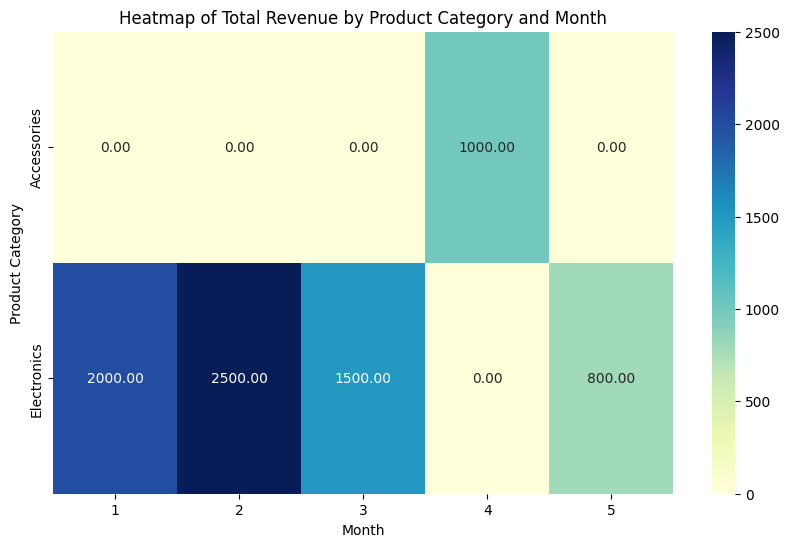

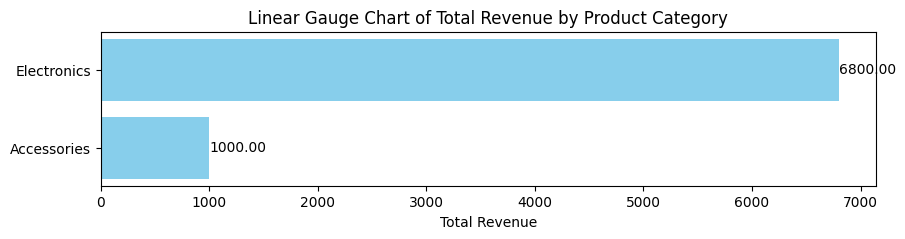

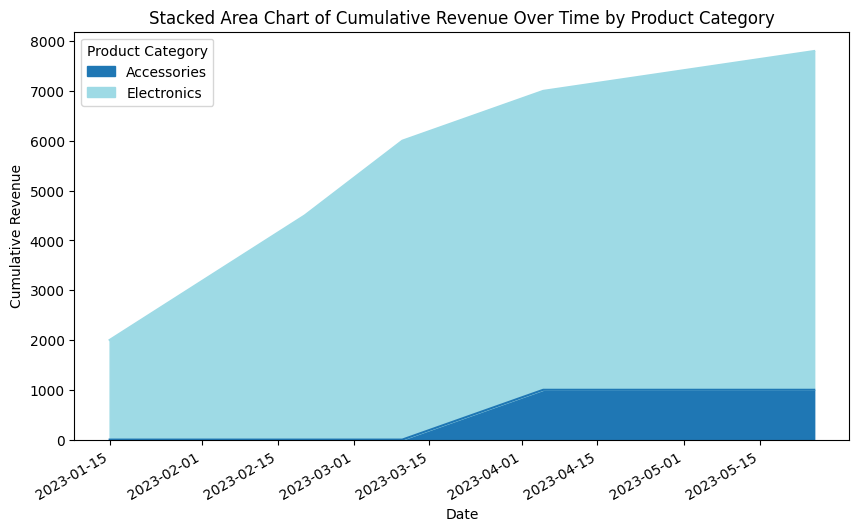

In [12]:
# Heatmap showing Total Revenue by Product Category and Month
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

heatmap_data = pd.pivot_table(sales_df, values='revenue', index='category',
                              columns='month', aggfunc=np.sum, fill_value=0)
## Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap of Total Revenue by Product Category and Month')
plt.xlabel('Month')
plt.ylabel('Product Category')
plt.show()

# linear gauge chart showing Total Revenue by Product Category
gauge_data = sales_df.groupby('category').agg(
    total_revenue=pd.NamedAgg(column='revenue', aggfunc='sum')
).reset_index()
## Plot linear gauge chart
plt.figure(figsize=(10, 2))
bars = plt.barh(gauge_data['category'], gauge_data['total_revenue'], color='skyblue')
plt.title('Linear Gauge Chart of Total Revenue by Product Category')
plt.xlabel('Total Revenue')
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')
plt.show()

# stacked area chart showing Cumulative Revenue Over Time by Product Category
area_data = sales_df.groupby(['date', 'category']).agg(
    total_revenue=pd.NamedAgg(column='revenue', aggfunc='sum')
).reset_index()
area_data = area_data.pivot(index='date', columns='category', values='total_revenue').fillna(0)
area_data = area_data.cumsum()
## Plot stacked area chart
plt.figure(figsize=(10, 6))
area_data.plot.area(ax=plt.gca(), cmap='tab20')
plt.title('Stacked Area Chart of Cumulative Revenue Over Time by Product Category')
plt.xlabel('Date')
plt.ylabel('Cumulative Revenue')
plt.legend(title='Product Category')
plt.show()